# Data Science como assunto no Twitter

O Twitter possui mais de 1,3 bilhões de usuários, sendo cerca de 46% dos usuários ativos diários. Por este motivo, este canal de comunicação pode ser usado como fonte de atualizações sobre os mais diversos temas.

No intuito de fomentar um ambiente de informações sobre Ciência de Dados, usamos o Twitter para analisar e tentar descobrir os usuários produtores de conteúdo. Além disso, entender um pouco as redes de informação sobre o assunto. Para isso aplicamos alguns processos de coleta, tratamento e análise de dados a partir de redes complexas.

## Coletando Dados

Os dados utilizados para análise são referentes a tweets coletados no dia 14/09/2021. Só foram selecionados aqueles que retweetaram publicações feitas com a hashtag “DataScience” (#DataScience). O arquivo com esses tweets encontra-se na pasta raíz deste diretório sob nome retweets.csv.

O processo de acesso da APi do Twitter para formar o CSV foi feito utilizando uma versão alterada do repositório: https://github.com/mmartiniano/tweet-tracker. A versão alterada está na pasta tweet-tracker.

## Construindo uma rede direcionada

Após coletarmos mais de 5.000 tweets, construiremos uma rede de conexões baseadas em tweets e retweets.

In [67]:
import pandas as pd

In [69]:
retweets = pd.read_csv('retweets.csv')
retweets.columns = ('id', 'datetime', 'user_location', 'text', 'retweeted', 'retweeter', 'hashtags', 'mentions')

In [70]:
retweets.head()

,id,datetime,user_location,text,retweeted,retweeter,hashtags,mentions
0,1437780263036129288,2021-09-14 14:08:22,Earth,RT @IainLJBrown: Artificial Intelligence Has C...,IainLJBrown,_100DaysOfCode,ArtificialIntelligence,IainLJBrown
1,1437780267821895685,2021-09-14 14:08:23,Jammu And Kashmir,RT @IainLJBrown: Artificial Intelligence Has C...,IainLJBrown,Bills_Bot,ArtificialIntelligence,IainLJBrown
2,1437780287262543880,2021-09-14 14:08:27,Germany,RT @IainLJBrown: Artificial Intelligence Has C...,IainLJBrown,hubofml,ArtificialIntelligence,IainLJBrown
3,1437780287719620608,2021-09-14 14:08:27,"England, United Kingdom",RT @NikseamC: Business Solution @NikseamC\n#F...,NikseamC,CarrieH3nry,FrontEndDeveloper DEVCommunity cybersecurity A...,NikseamC NikseamC
4,1437780311241379849,2021-09-14 14:08:33,NaN,RT @NikseamC: Business Solution @NikseamC\n#F...,NikseamC,iPythonistaBot,FrontEndDeveloper DEVCommunity cybersecurity A...,NikseamC NikseamC


In [71]:
retweets.shape

(5993, 8)


Na rede a ser formada os nós são usuários do Twitter e as conexões representam retweets, seguindo a direção do fluxo de informação: Tweet Original -> Retweet. Assim, dois usuários são ligados caso algum deles tenha feito o compartilhamento da publicação do outro, portanto as conexões possuem uma direção definida que caracteriza a rede formada como direcionada.

In [72]:
import networkx as nx

In [73]:
D = nx.DiGraph()

for row in retweets.itertuples(index=False):
  if D.has_edge(row.retweeted, row.retweeter):
    D.edges[row.retweeted, row.retweeter]['weight'] += 1
  else:
    D.add_edge(row.retweeted, row.retweeter, weight=1)

## Analisando a rede construída

No contexto de redes complexas ou grafos, chamados de grau a quantidade de ligações de um determinado nó. Em redes direcionadas, o grau pode ser dividido em dois agrupamentos: o número de conexões que saem do nó (Grau de Saída) e quantidade de conexões que apontam para o nó (Grau de Entrada).

Essas e outras informações são cruciais para conseguirmos identificar os nós mais importantes da rede analisada. Porém precisamos levar em conta todo o contexto em que a rede está aplicada para determinar qual atributo dos nós é mais condizente com a realidade e representa uma relevância mais fiel.

Como as ligações seguem a direção do fluxo de informação, o grau de saída representa a quantidade de usuários que retuitaram um determinado nó. Assim utilizamos essa métrica para verificar quais usuários foram mais compartilhados por uma quantidade distinta de pessoas.

In [74]:
from operator import itemgetter

sorted(D.out_degree(), key=itemgetter(1), reverse=True)[:5]

[('gp_pulipaka', 78),
 ('PrUkkera', 65),
 ('Khulood_Almani', 54),
 ('IainLJBrown', 53),
 ('Eli_Krumova', 50)]

Usuário que foi retweetado por um número maior de pessoas: https://twitter.com/gp_pulipaka

Seguindo este processo, não levamos em conta a quantidade de vezes que um usuário compartilhou tweets de outro, para isso, usamos o grau de saída ponderado. Enquanto a métrica anterior informava sobre a quantidade de usuários “alcançados”, essa é mais sensível a quantidade de vezes que um mesmo usuário retweetou o outro.

In [75]:
sorted(D.out_degree(weight='weight'), key=itemgetter(1), reverse=True)[:5]

[('SajjadA12488597', 275),
 ('IainLJBrown', 184),
 ('gp_pulipaka', 165),
 ('NikseamC', 140),
 ('bluejak3', 140)]

Usuário mais retweetado: https://twitter.com/SajjadA12488597

### Qual métrica usar?

No Twitter é comum a prática do uso de bots, segundo dados da plataforma cerca de 15% do seu público ativo não são seres humanos. Isso nos fez questionar sobre qual métrica nos entregaria resultados mais fieis com o proposto em nossa análise.

Sabendo dessa informação procuramos analisar os dados coletados para detectar possíveis anomalias na nossa rede. Um fenômeno comum em redes sociais são contas que criam poucos conteúdos originais e, no caso do Twitter, ficam apenas retuitando o conteúdo de outras contas.

Para concretizar esse pensamento desenhamos um histograma formado pela distribuição pelos valores de grau de entrada (Retuites feitos) por cada nó da rede.

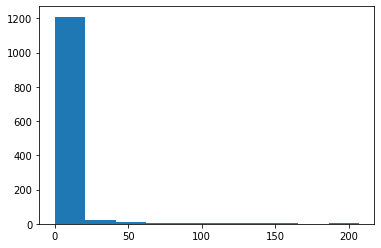

In [76]:
import matplotlib.pyplot as plt

plt.hist(dict(D.in_degree(weight='weight')).values())
plt.show()

Analisando o gráfico mostrado, conseguimos perceber que a quantidade comum de compartilhamentos por nó é menor do que 50. Um pequeno grupo de usuários ficou concentrado entre 100 ~ 200 retweets, esse comportamento nos chamou a atenção e foi classificado como anomalia dentro da rede, provavelmente causada por bots.

In [77]:
sorted(D.in_degree(weight='weight'), key=itemgetter(1), reverse=True)[:10]

[('iPythonistaBot', 207),
 ('AzuerBot', 189),
 ('AdvanceML', 188),
 ('CoderRetweet', 164),
 ('team_backend', 163),
 ('100DaysOf2020', 154),
 ('hubofml', 150),
 ('elizabot9', 149),
 ('DeveloperBot_v1', 142),
 ('CodeWithTwitchi', 139)]

Das contas listadas acima, todas são atualizadas por processos automáticos ou bots.


### Tratando Anomalias


In [78]:
core = [node for node, deg in dict(D.in_degree(weight='weight')).items() if deg <= 50]

dsub = nx.subgraph(D, core)

print("{} nodes, {} edges".format(len(dsub), nx.number_of_edges(dsub)))

nx.write_graphml(dsub, "retweet_sub.graphml")

1243 nodes, 1988 edges


In [79]:
sorted(dsub.out_degree(), key=itemgetter(1), reverse=True)[:5]

[('gp_pulipaka', 60),
 ('PrUkkera', 44),
 ('Khulood_Almani', 35),
 ('IainLJBrown', 34),
 ('sayalook', 32)]

In [56]:
sorted(dsub.out_degree(weight='weight'), key=itemgetter(1), reverse=True)[:5]

[('gp_pulipaka', 89),
 ('akbarth3great', 86),
 ('bluejak3', 75),
 ('SajjadA12488597', 66),
 ('IainLJBrown', 64)]

In [57]:
dsubnl = dsub.copy()

In [58]:
dsubnl.remove_edges_from(nx.selfloop_edges(dsubnl))

In [59]:
max(dsub.nodes, key=dsub.out_degree)

'gp_pulipaka'

In [60]:
sorted(dsub.out_degree(), key=itemgetter(1), reverse=True)[:5]

[('gp_pulipaka', 60),
 ('PrUkkera', 44),
 ('Khulood_Almani', 35),
 ('IainLJBrown', 34),
 ('sayalook', 32)]

In [61]:
sorted(dsub.out_degree(weight='weight'), key=itemgetter(1), reverse=True)[:5]

[('gp_pulipaka', 89),
 ('akbarth3great', 86),
 ('bluejak3', 75),
 ('SajjadA12488597', 66),
 ('IainLJBrown', 64)]

In [22]:
nx.write_graphml(D, 'retweets.graphml')